In [39]:
from mlcomp.data.load import load_classification_train
from mlcomp.data import preprocess
from imblearn.over_sampling import SMOTE
import shap
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

In [40]:
train = load_classification_train()
train = preprocess.drop_ft2(train)
train = preprocess.remove_outliers(train, handling_method=preprocess.HandlingMethod.CAP_AT_MIN_MAX)

X_train = train.drop(columns='label')
y_train = train['label']

X_train, y_train = SMOTE().fit_resample(X_train, y_train)

In [41]:
cat = CatBoostClassifier(eval_metric="TotalF1", random_state=42)

hp = {
    "bagging_temperature": 9.933171093235632,
    "depth": 4,
    "l2_leaf_reg": 5.420115711716861,
    "random_strength": 0.3008985550781157,
    "logging_level": "Silent"
}
cat.set_params(**hp)
cat.fit(X_train, y_train, verbose=False)

In [42]:
ex = shap.TreeExplainer(cat)
shap_values = ex(X_train)

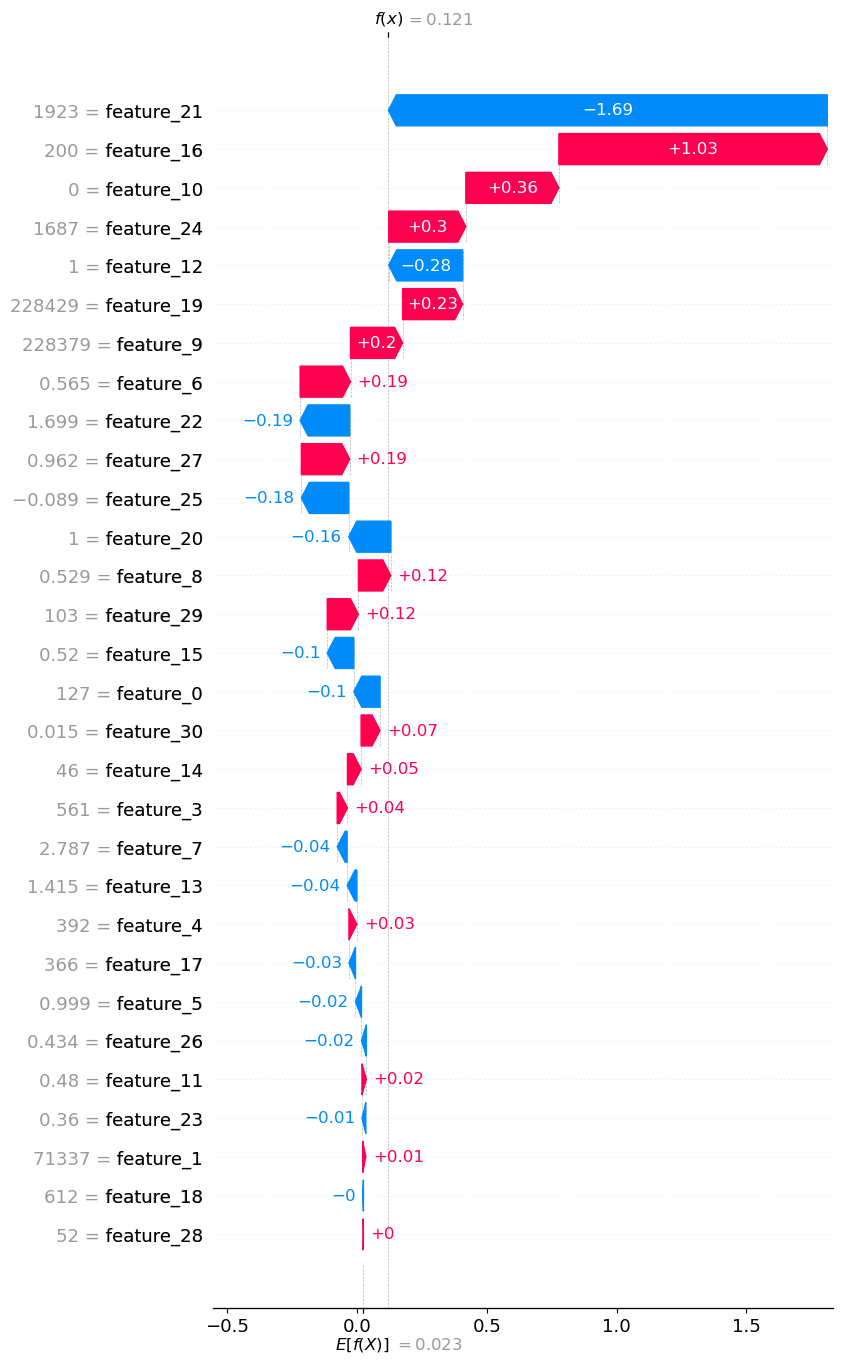

In [43]:
shap.plots.waterfall(shap_values[15], max_display=40)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


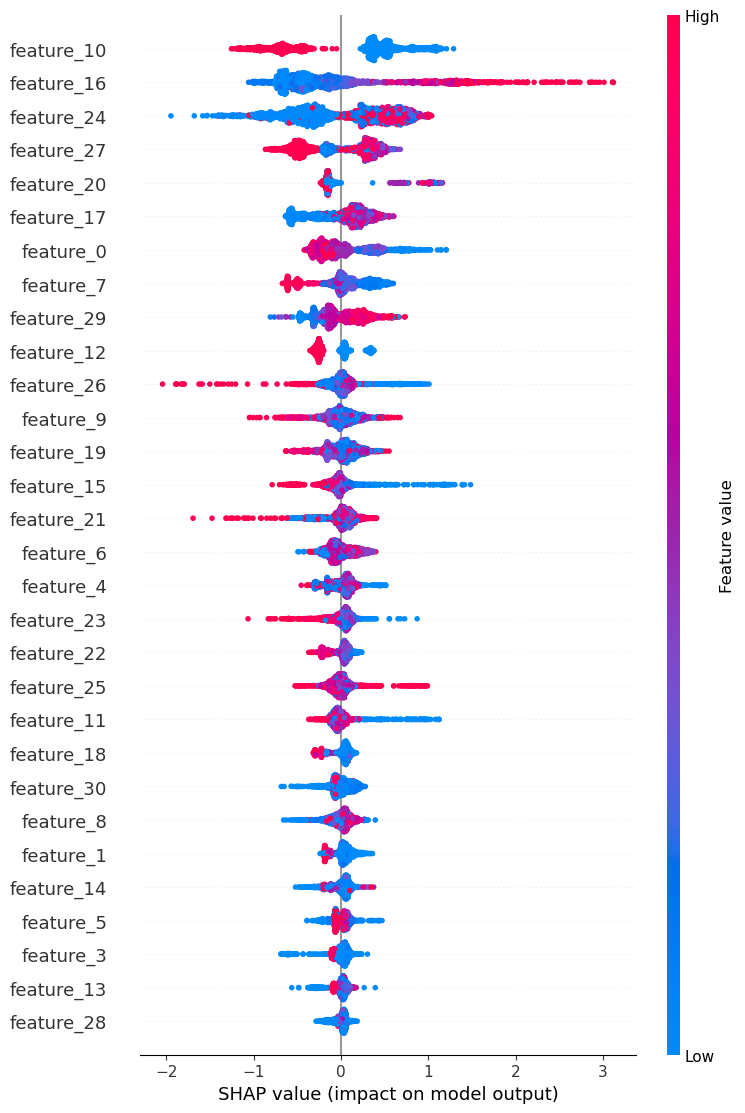

In [44]:
shap.plots.beeswarm(shap_values, max_display=40)

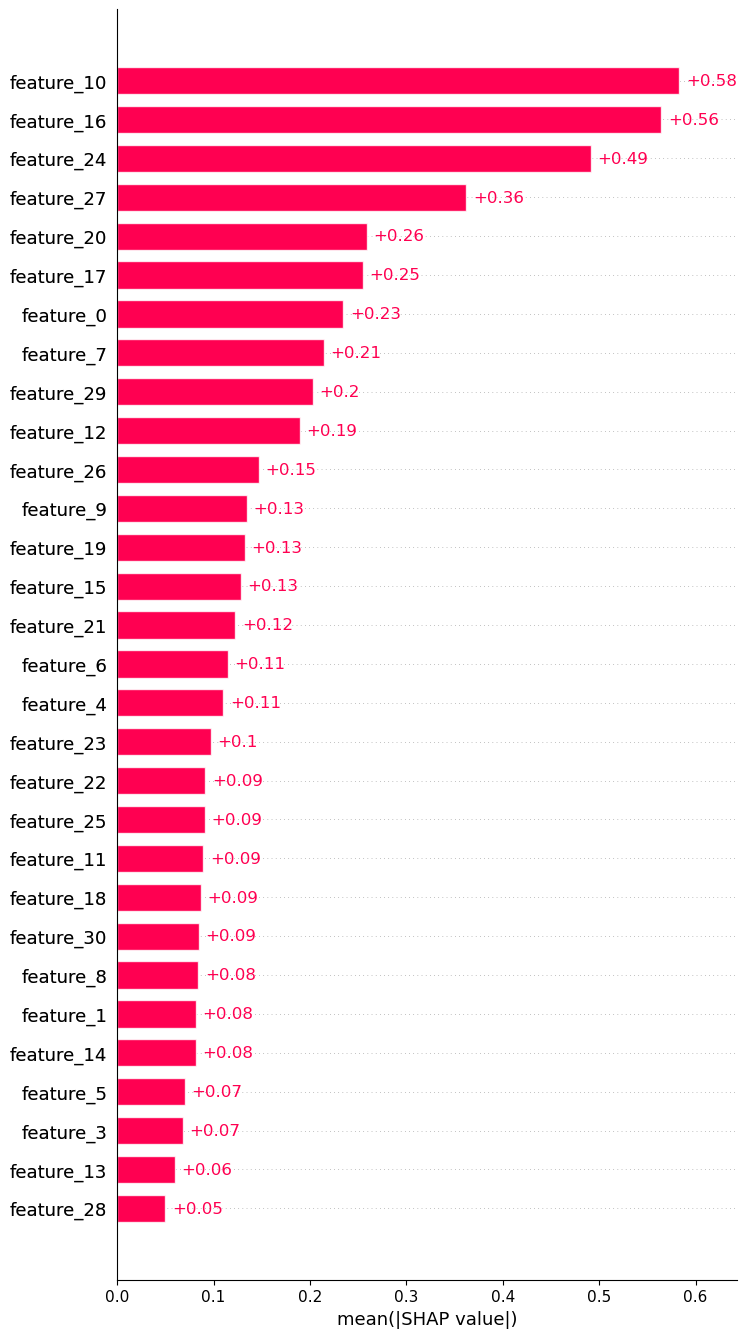

In [45]:
shap.plots.bar(shap_values, max_display=40)

In [ ]:
shap_ranking = X_train.columns[np.argsort(np.abs(shap_values.values).mean(0))]
print(f'Shap ranking: {shap_ranking}')
# successively remove features based on mean shap value
for i in range(len(shap_ranking)):
    cat = CatBoostClassifier(eval_metric="TotalF1", random_state=42)
    cat.set_params(**hp)
    X_removed = X_train.drop(columns=shap_ranking[:i])
    print(f'i: {i}, f1 (5vc): {cross_val_score(cat, X_removed, y_train, scoring="f1_macro").mean()}')

#### Result:
- Highest score with i=7, this means dropping ['feature_28', 'feature_14', 'feature_8', 'feature_11', 'feature_18','feature_30', 'feature_4']